# FPN
## Reference
* [Feature Pyramid Network for Object detectoin](https://arxiv.org/pdf/1612.03144.pdf)

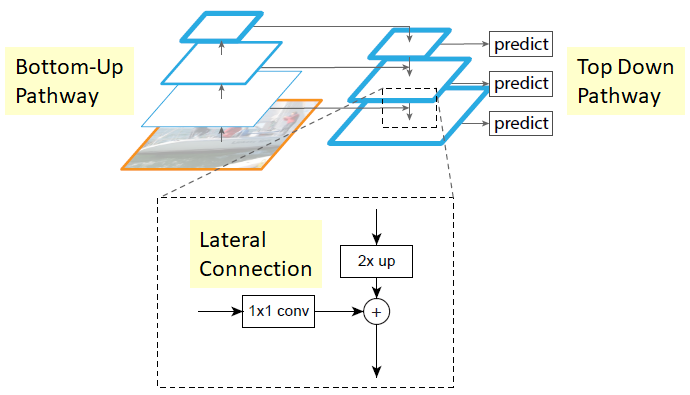

Depth of FPN's conv layer is 256 and have no activation function
1. For reduce demention, apply 1x1 conv layer to corresponding feature map of  bottom up pathway
2. Add to upsampled feature map
3. Apply 3x3 conv layer for organizing.

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, backend

In [2]:
def idnetity_block(input_tensor, n_filter: list):
  F1, F2, F3 = n_filter
  # 1x1 conv layer
  x = layers.BatchNormalization()(input_tensor)
  x = layers.ReLU()(x)
  x = layers.Conv2D(filters=F1, kernel_size=(1, 1), strides=1, padding='valid')(x)

  # 3x3 conv layer
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = layers.Conv2D(filters=F2, kernel_size=(3, 3), strides=1, padding='same')(x)

  # 1x1 conv layer
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = layers.Conv2D(filters=F3, kernel_size=(1, 1), strides=1, padding='valid')(x)

  # shortcut connection
  x = layers.add([x, input_tensor])
  return x

In [3]:
def conv_block(input_tensor, n_filter: list):
  F1, F2, F3 = n_filter
  # 1x1 conv layer
  x = layers.BatchNormalization()(input_tensor)
  x = layers.ReLU()(x)
  x = layers.Conv2D(filters=F1, kernel_size=(1, 1), strides=2, padding='valid')(x)

  # 3x3 conv layer
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = layers.Conv2D(filters=F2, kernel_size=(3, 3), strides=1, padding='same')(x)

  # 1x1 conv layer
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = layers.Conv2D(filters=F3, kernel_size=(1, 1), strides=1, padding='valid')(x)

  # shortcut connection
  skip = layers.Conv2D(filters=F3, kernel_size=(1, 1), strides=2, padding='valid')(input_tensor)
  x = layers.add([x, skip])

  return x

In [6]:
def bottom_up(x):
  # 1st stage
  x = layers.ZeroPadding2D(padding=(3, 3))(X)
  x = layers.Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2), padding='valid')(x)

  # 2nd stage
  x = layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x) # (56, 56, 64)
  x = conv_block(x, [64, 64, 256])
  x = idnetity_block(x, [64, 64, 256])
  C2 = idnetity_block(x, [64, 64, 256])

  # 3rd stage
  x = conv_block(C2, [128, 128, 512])
  x = idnetity_block(x, [128, 128, 512])
  x = idnetity_block(x, [128, 128, 512])
  C3 = idnetity_block(x, [128, 128, 512])

  # 4th stage
  x = conv_block(C3, [256, 256, 1024])
  for i in range(22):
    x = idnetity_block(x, [256, 256, 1024])
  C4 = x

  # 5th stage
  x = conv_block(C4, [512, 512, 2048])
  x = idnetity_block(x, [512, 512, 2048])
  C5 = idnetity_block(x, [512, 512, 2048])

  return [C2, C3, C4, C5]

In [7]:
def top_down(input_tensors: list):
  C2, C3, C4, C5 = input_tensors
  P5 = layers.Conv2d(filters=256, kernel_size=1, strides=1, padding='valid')(C5)
  P5 = layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(P5)

  P4 = layers.UpSampling2D()(P5)
  P4 = layers.Add([P4, layers.Conv2D(filters=256, kernel_size=1, padding='valid')(C4)])
  P4 = layers.Conv2D(filters=256, kernel_size=3, padding='same')(P4)

  P3 = layers.UpSampling2D()(P4)
  P3 = layers.Add([P3, layers.Conv2D(filters=256, kernel_size=1, padding='valid')(C3)])
  P3 = layers.Conv2D(filters=256, kernel_size=3, padding='same')(P3)

  P2 = layers.UpSampling2D()(P3)
  P2 = layers.Add([P2, layers.Conv2D(filters=256, kernel_size=1, padding='valid')(C2)])
  P2 = layers.Conv2D(filters=256, kernel_size=3, padding='same')(P2)
  return [P2, P3, P4, P5]